<a href="https://colab.research.google.com/github/ggruszczynski/gpu_colab/blob/main/80_gpu_aos_vs_soa_mem_layout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Memory layout - porting issues

Consider a set of points (x,y,z) describing some geometry...

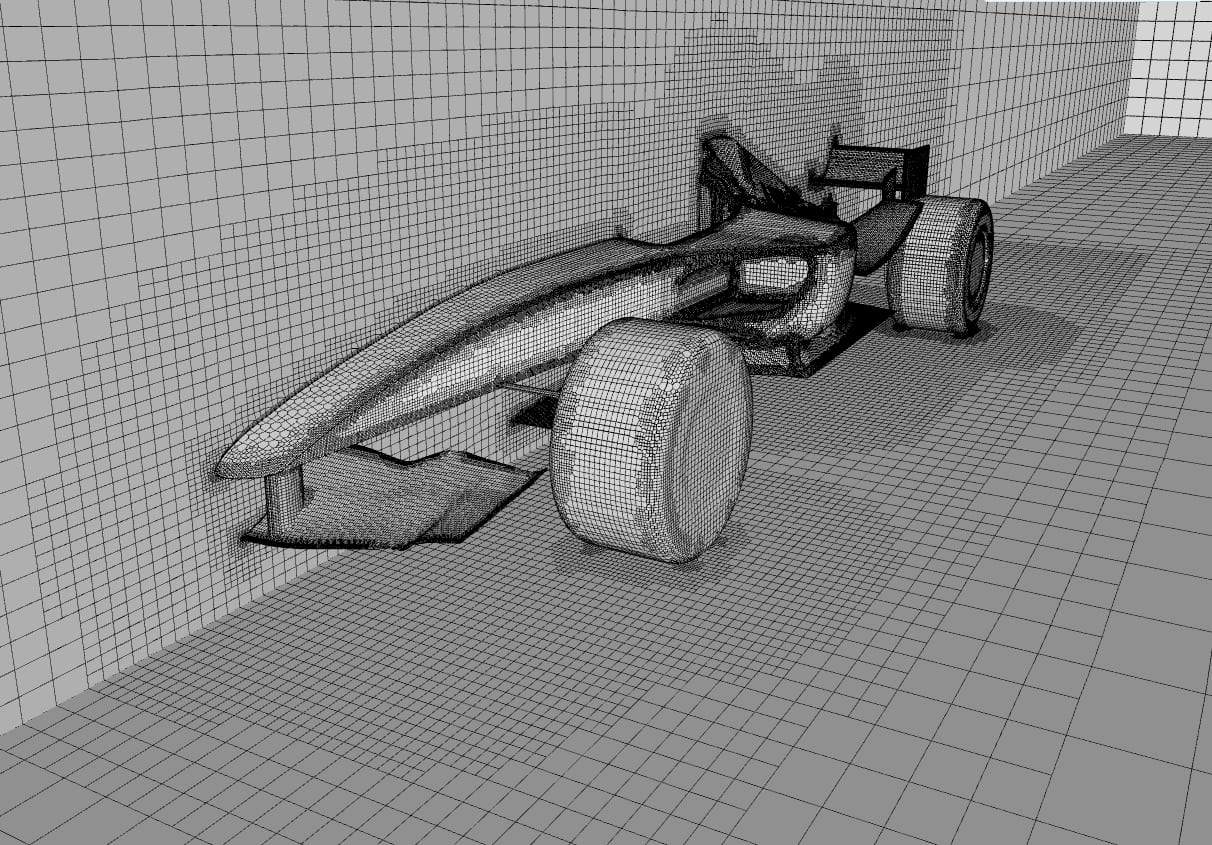

In [1]:
!nvidia-smi

Sun Apr 30 12:16:53 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from numba import cuda
from numba import jit
import numpy as np
import math
from numba import vectorize, int8, int32, int64, float32, float64
import matplotlib.pyplot as plt

np.set_printoptions(precision=1, suppress=True)

%matplotlib inline

M = 2**13     # ~1000MB 
# M = 2**10   # ~10MB works better with SOA
# M = 2**6    # <1MB, no difference

N = 3*M**2

a = np.arange(N, dtype=np.float64) # [0...N] on the host
print(f"Total number of elements: {N} \nDimensions of the matrix MxM: {M} \nMemory size of array in [MB]: {a.nbytes/1E6}")


Total number of elements: 201326592 
Dimensions of the matrix MxM: 8192 
Memory size of array in [MB]: 1610.612736


In [3]:
threadsperblock = (32,32)
blockspergrid_x = math.ceil(M / threadsperblock[0])
blockspergrid_y = math.ceil(M / threadsperblock[1])
# blockspergrid_z = math.ceil(d_a.shape[2] / threadsperblock[2])
blockspergrid = (blockspergrid_x, blockspergrid_y)
total_threads_in_block = threadsperblock[0]*threadsperblock[1]
assert total_threads_in_block <= 1024 # hardware limit
assert total_threads_in_block <= M # avoid useless threads

print(f"Blockspergrid: {blockspergrid}, Total number of threads in a block: {total_threads_in_block}")

Blockspergrid: (256, 256), Total number of threads in a block: 1024


# AOS (Array of Structures)

The MxM matrix stores Points(x,y,z) in its most inner dimension


In [17]:
arr_aos = a.reshape(M,M,3)        # The MxM matrix stores Points(x,y,z) in its most inner dimension
aos_out = np.zeros_like(arr_aos)
print(f" Shape: {arr_aos.shape} \n Strides {arr_aos.strides} \n Content {arr_aos[0,0:3,:]}")

d_arr_aos = cuda.to_device(arr_aos)           # Copy array from host to the device
d_aos_out = cuda.device_array_like(d_arr_aos) # preallocate an arracy filled with 0

# print(f"GPU result:\n {d_aos_out.copy_to_host()[0,0:3,:]}")

 Shape: (8192, 8192, 3) 
 Strides (196608, 24, 8) 
 Content [[0. 1. 2.]
 [3. 4. 5.]
 [6. 7. 8.]]


In [5]:
def cpu_aos(M, A_in,  A_out):    
    for tidx in range(M):
      for tidy in range(M):
        A_out[tidx][tidy][2] = A_in[tidx][tidy][2] + 1000

@cuda.jit
def kernel_gpu_aos(M, A_in, A_out):
    tidx, tidy = cuda.grid(2)
    # The above is equivalent to the following 2 lines of code:
    # x = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
    # y = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y
    
    # loop over all points in domain (except boundary)
    if (tidx < M and tidy < M):
        A_out[tidx][tidy][2] = A_in[tidx][tidy][2] + 1000

In [18]:
%timeit kernel_gpu_aos[blockspergrid, threadsperblock](M, d_arr_aos, d_aos_out)

25.6 ms ± 34 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [7]:
# %timeit  
# cpu_aos(M, arr_aos, aos_out) #to slow

In [8]:
# print(f"CPU result:\n {aos_out[0,0:3,:]}")
print(f"GPU result:\n {d_aos_out.copy_to_host()[0,0:3,:]}")

GPU result:
 [[   0.    0. 1002.]
 [   0.    0. 1005.]
 [   0.    0. 1008.]]


## Cleanup

In [9]:
del arr_aos
del aos_out

del d_arr_aos
del d_aos_out

# SOA (Structure of Arrays)

Each of the MxM matrices stores only the x, y or z coordinates.

In [10]:
arr_soa = a.reshape(3,M,M)                     # Each of the most outer dimensions stores a MxM matrix stores only x, y or z coordinates.
out_soa = np.zeros_like(arr_soa)

print(f" Shape: {arr_soa.shape} \n Strides {arr_soa.strides} \n Content {arr_soa[2,0,:10]}")

d_arr_soa = cuda.to_device(arr_soa)            # Copy array from host to the device
d_soa_out = cuda.device_array_like(d_arr_soa)  # preallocate an arracy filled with 0

 Shape: (3, 8192, 8192) 
 Strides (536870912, 65536, 8) 
 Content [1.3e+08 1.3e+08 1.3e+08 1.3e+08 1.3e+08 1.3e+08 1.3e+08 1.3e+08 1.3e+08
 1.3e+08]


In [11]:
def cpu_soa(M, A_in,  A_out):    
    for tidx in range(M):
      for tidy in range(M):
        A_out[2][tidx][tidy] = A_in[2][tidx][tidy] + 1000

@cuda.jit
def kernel_gpu_soa(M, A_in,  A_out):
    tidx, tidy = cuda.grid(2)
    # The above is equivalent to the following 2 lines of code:
    # x = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
    # y = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y
    
    # loop over all points in domain (except boundary)
    if (tidx < M and tidy < M):
       A_out[2][tidx][tidy] = A_in[2][tidx][tidy] + 1000

In [12]:
%timeit kernel_gpu_soa[blockspergrid, threadsperblock](M, d_arr_soa, d_soa_out)

10.7 ms ± 79.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [13]:
# %timeit 
# cpu_soa(M, arr_soa, out_soa)  #to slow

In [14]:
# print(f"CPU result:\n {out_soa[2,0,:10]}")
print(f"GPU result:\n {d_soa_out.copy_to_host()[2,0,:10]}")

GPU result:
 [1.3e+08 1.3e+08 1.3e+08 1.3e+08 1.3e+08 1.3e+08 1.3e+08 1.3e+08 1.3e+08
 1.3e+08]


## Cleanup

In [15]:
del arr_soa
del out_soa

del d_arr_soa
del d_soa_out